In [136]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from draw_signal import draw_signal
from scipy.signal import find_peaks, argrelextrema
import os

In [137]:
test = np.loadtxt('1_L.txt', delimiter=',')
test.shape

(978,)

In [138]:
def distances(link_json):
  file_name = link_json.split(sep='\\')[-1]
  task, side = file_name.split(sep='_')[0][-1], file_name.split(sep='_')[1]

  if (side=='L'):
    hand = 'left hand'
    noise_hand = 'right hand'
  else:
    hand = 'right hand'
    noise_hand = 'left hand'
  
  with open(link_json, 'r', encoding = 'utf8') as f:
    text = json.load(f)

  frame = 0
  d = []
  if (task=='1'):
    for i in range(len(text)):
      if noise_hand in text[i].keys():
        pass
      else:
        sum_sqr = (float(text[i][hand]['FORE_TIP']['X1']) -
                           float(text[i][hand]['THUMB_TIP']['X1'])) ** 2 + (
                                  float(text[i][hand]['FORE_TIP']['Y1']) -
                                  float(text[i][hand]['THUMB_TIP']['Y1'])) ** 2 + (
                                      float(text[i][hand]['FORE_TIP']['Z1']) -
                                      float(text[i][hand]['THUMB_TIP']['Z1'])) ** 2
        d.append(math.sqrt(sum_sqr))
        frame += 1
      
      

  elif (task=='2'):
    for i in range(len(text)):
       sum_sqr = (float(text[i][hand]['MIDDLE_TIP']['X1']) -
                           float(text[i][hand]['CENTRE']['X1'])) ** 2 + (
                                  float(text[i][hand]['MIDDLE_TIP']['Y1']) -
                                  float(text[i][hand]['CENTRE']['Y1'])) ** 2 + (
                                      float(text[i][hand]['MIDDLE_TIP']['Z1']) -
                                      float(text[i][hand]['CENTRE']['Z1'])) ** 2
       d.append(math.sqrt(sum_sqr))

  elif (task=='3'):
    for i in range(len(text)):
       sum_sqr = float(text[i][hand]['CENTRE']['Angle'])
       d.append(sum_sqr)

  else:
    sum_sqr = 0
    d.append(math.sqrt(sum_sqr))
  return np.arange(frame), np.array(d)


Get signals from LM & MP

In [139]:
path = 'C:\\Users\\fixen\\'

# From Leap Motion
# frames_lm, dist_lm = distances(path + 'Documents\\BMSTU\\PD\\Release_v1\\Patient85\\hand\\leapRecording1_L_m1_patient85.json')
frames_lm, dist_lm = distances(path + 'Documents\\BMSTU\\PD\\Release_v1\\Test1\\hand\\leapRecording1_R_m1_Test1.json')
t_lm = frames_lm * (1/115)

# From Mediapipe
# s = np.load(path + 'Videos\\PD hand videos\\Patient85\\m1\\1_L.npy', allow_pickle=True)
s = np.load(path + 'Documents\\BMSTU\\PD\\Release_v1\\Test1\\videos\\1_R.npy', allow_pickle=True)

dist_mp, frames_mp = draw_signal(s, 1, grap=False)
dist_mp, frames_mp = np.array(dist_mp), np.array(frames_mp)
# dist_mp = np.loadtxt('1_R.txt', delimiter=',')
frames_mp = np.arange(len(dist_mp))
t_mp = frames_mp * (1/30)

# Normalize
dist_lm -= min(dist_lm)
dist_lm /= max(dist_lm)
dist_mp -= min(dist_mp)
dist_mp /= max(dist_mp)


Get points from videos and save as npy array (this cell is used only once)

In [141]:
# from get_points import get_points
# path_to_videos = 'C:\\Users\\fixen\\Documents\\BMSTU\\PD\\Release_v1\\Test1\\videos'
# videos_list = os.listdir(path_to_videos)
# for file_name in videos_list:
#     s = get_points(path_to_videos + '\\' + file_name)
#     np.save(path_to_videos + file_name, s)
# s = get_points('C:\\Users\\fixen\\Documents\\BMSTU\\PD\\Release_v1\\Test1\\videos\\1_L.MOV')

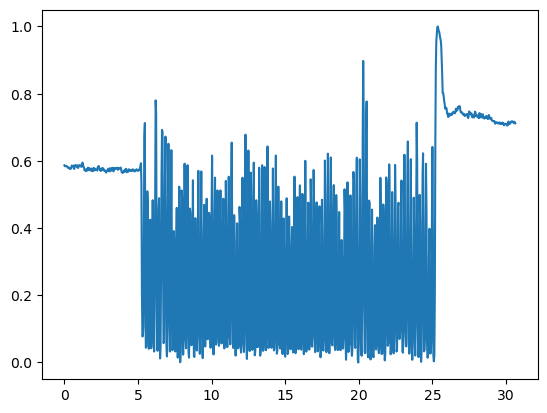

In [142]:
plt.plot(t_mp, dist_mp)

Plot two signals

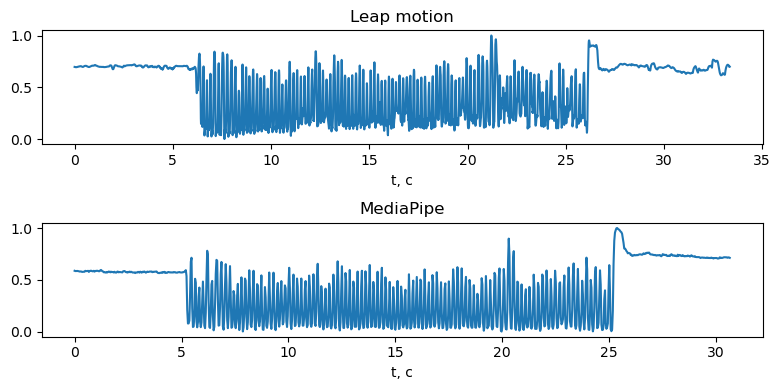

In [144]:
plt.figure(figsize=(8,4))

plt.subplot(2,1,1)
plt.plot(t_lm, dist_lm)
plt.title('Leap motion')
plt.xlabel('t, с')

plt.subplot(2,1,2)
plt.plot(t_mp, dist_mp)
plt.title('MediaPipe')
plt.xlabel('t, с')

plt.tight_layout()


Sync by first lowest peak

(7.0, 9.0)

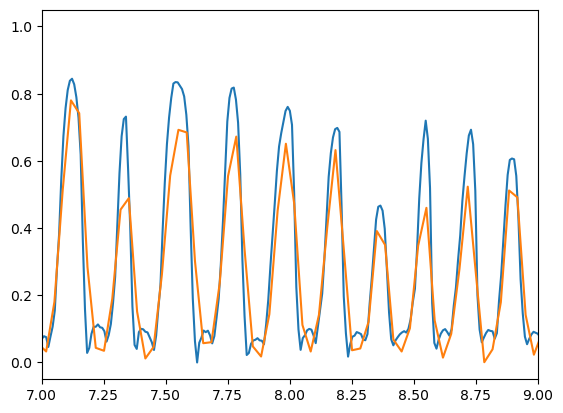

In [145]:

low_peaks_lm = argrelextrema(dist_lm, np.less, order=14)[0]
first_low_peak_lm, last_low_peak_lm = low_peaks_lm[dist_lm[low_peaks_lm] < 0.5][0], low_peaks_lm[dist_lm[low_peaks_lm] < 0.5][-1]

low_peaks_mp = argrelextrema(dist_mp, np.less, order=5)[0] 
first_low_peak_mp, last_low_peak_mp = low_peaks_mp[dist_mp[low_peaks_mp] < 0.2][0], low_peaks_mp[dist_mp[low_peaks_mp] < 0.2][-1]

time_lag = t_mp[first_low_peak_mp] - t_lm[first_low_peak_lm]

t_lm_sync = t_lm[first_low_peak_lm:last_low_peak_lm]
dist_lm_sync = dist_lm[first_low_peak_lm:last_low_peak_lm]
t_mp_sync = t_mp[first_low_peak_mp:last_low_peak_mp] - time_lag
dist_mp_sync = dist_mp[first_low_peak_mp:last_low_peak_mp]

plt.plot(t_lm_sync, dist_lm_sync)
plt.plot(t_mp_sync, dist_mp_sync)
plt.xlim(7, 9)

In [146]:
class Signal():
    '''
    Class Signal represents signal values, time. Later amplitude and period are also put into class
    '''
    def __init__(self, t, s):
        self.t = t
        self.s = s

In [147]:
lm = Signal(t_lm_sync, dist_lm_sync)
mp = Signal(t_mp_sync, dist_mp_sync)

In [148]:
def equate_arrays_shape(arr1, arr2):
    '''
    Make two arrays equal of size
    '''
    arr1 = arr1[:min(arr1.shape[0], arr2.shape[0])]
    arr2 = arr2[:min(arr1.shape[0], arr2.shape[0])]
    return arr1, arr2

In [149]:
def calc_signal_properties(signal, label):

    # Calculate signal parameters
    max_peaks = argrelextrema(signal.s, np.greater, order=4)[0]
    min_peaks = argrelextrema(signal.s, np.less, order=4)[0]

    plt.plot(signal.t, signal.s, label=label)
    # plt.scatter(signal.t[min_peaks], signal.s[min_peaks], color='g')
    # plt.scatter(signal.t[max_peaks], signal.s[max_peaks], color='r')
    plt.xlim(7.5, 9)
    plt.xlabel('t, с')
    plt.legend()

    # Equate peaks arrays shape
    max_peaks, min_peaks = equate_arrays_shape(max_peaks, min_peaks)

    signal.amplitudes = signal.s[max_peaks] - signal.s[min_peaks]
    signal.periods = signal.t[max_peaks][1:] - signal.t[max_peaks][:-1]

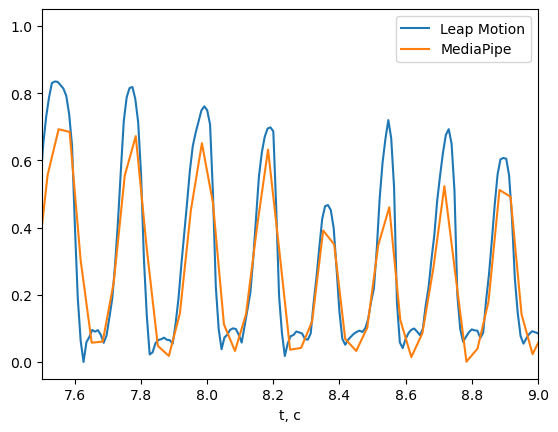

In [150]:
calc_signal_properties(lm, 'Leap Motion')
calc_signal_properties(mp, 'MediaPipe')

Calculate sync parameters

In [151]:
lm.amplitudes, mp.amplitudes = equate_arrays_shape(lm.amplitudes, mp.amplitudes)
delta_ampl = mp.amplitudes - lm.amplitudes
delta_ampl_avg = np.mean(delta_ampl)

lm.periods, mp.periods = equate_arrays_shape(lm.periods, mp.periods)
delta_period = mp.periods - lm.periods
delta_period_avg = np.mean(delta_period)

print(delta_ampl_avg, delta_period_avg)

0.13181641745896322 0.07147293700088733
